# Renew Power Hiring Hackathon


#### Coded by:      Albert Antony

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime as dt

# Modelling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV  
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import category_encoders as ce
from hyperopt.fmin import fmin
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, SparkTrials

# Warnings
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize']=(20,12)

C:\Users\antony.a\Anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [28]:
# Metrics
def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true) - X_test.shape[1]-1)
    return adjusted_r2

def MAPE(y_actual,y_pred):
    mape = np.mean(np.abs((y_actual - y_pred)/y_actual))*100
    return mape

In [2]:
%%time
train = pd.read_csv('train.csv' )
test = pd.read_csv('test.csv')
submission= pd.read_csv('submission.csv')

CPU times: total: 2.95 s
Wall time: 3.29 s


# Checking for Duplicate entries

In [3]:
## No duplicates found
train[train.duplicated()==True]

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target


# Checking Missing Values

In [4]:
# Missing Values not found
train.isnull().sum()

timestamp                                 0
active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
turbine_id                                0
Target                                    0
dtype: int64

In [5]:
train.describe()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target
count,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000,909604.000000
mean,525.886061,537.639468,25.573921,931.130882,60.730112,527.579537,31.755823,31.686413,111.080610,133.692333,199.487161,5.894950,0.651916,46.328595
std,474.619576,482.394907,8.025649,193.674384,9.721582,472.656976,3.929794,3.554426,78.219944,91.232152,104.617261,1.977684,0.317513,2.617691
min,0.000000,0.000008,5.616541,0.000000,25.636366,0.000000,11.141922,16.010218,-318.393721,-5.461607,0.309692,0.904500,0.000000,25.865320
25%,149.620898,155.813244,17.093680,770.538574,54.916767,147.181552,29.913803,30.267423,81.540850,96.045765,98.916060,4.400753,0.432129,44.816740
50%,379.989929,383.985926,27.919035,884.068502,60.034490,391.303187,31.762946,31.961610,92.005826,107.633378,232.821159,5.637207,0.583863,46.302899
75%,781.357475,800.261108,32.171696,1123.335856,65.737187,794.875710,33.469745,33.546260,124.879153,154.153730,287.667503,7.092771,0.798240,47.733105
max,1999.999858,1999.984456,48.089017,1267.140625,129.846405,1999.991455,52.790030,48.406106,523.892695,592.815938,359.455531,19.795001,9.534769,65.037689


In [6]:
train.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909604 entries, 0 to 909603
Data columns (total 16 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               909604 non-null  object 
 1   active_power_calculated_by_converter    909604 non-null  float64
 2   active_power_raw                        909604 non-null  float64
 3   ambient_temperature                     909604 non-null  float64
 4   generator_speed                         909604 non-null  float64
 5   generator_winding_temp_max              909604 non-null  float64
 6   grid_power10min_average                 909604 non-null  float64
 7   nc1_inside_temp                         909604 non-null  float64
 8   nacelle_temp                            909604 non-null  float64
 9   reactice_power_calculated_by_converter  909604 non-null  float64
 10  reactive_power                          9096

In [8]:
train.drop('timestamp',axis=1,inplace=True)

# Build Train and test sets from train dataset for evaluation

In [10]:
features = train[['active_power_calculated_by_converter','active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',     
        'reactice_power_calculated_by_converter' , 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence']]
target = train['Target']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.01, random_state=42)
X_train.shape, X_test.shape

((900507, 13), (9097, 13))

# Build a Baseline Model with Raw Features
##### No feature engineering, just basic null removal for data wrangling. Let's build a quick baseline model on the raw features and evaluate its performance

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900507 entries, 422666 to 121958
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    900507 non-null  float64
 1   active_power_raw                        900507 non-null  float64
 2   ambient_temperature                     900507 non-null  float64
 3   generator_speed                         900507 non-null  float64
 4   generator_winding_temp_max              900507 non-null  float64
 5   grid_power10min_average                 900507 non-null  float64
 6   nc1_inside_temp                         900507 non-null  float64
 7   nacelle_temp                            900507 non-null  float64
 8   reactice_power_calculated_by_converter  900507 non-null  float64
 9   reactive_power                          900507 non-null  float64
 10  wind_direction_raw                     

In [ ]:
%%time
xgr = XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

rsq_baseline_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_baseline_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_baseline_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
mape_baseline_xgb = MAPE(y_actual=y_test, y_pred=y_pred)
print('R-sq:', rsq_baseline_xgb)
print('Adj. R-sq:', adj_rsq_baseline_xgb)
print('RMSE:', rmse_baseline_xgb)
print('MAPE:', mape_baseline_xgb)

# Feature Engineering

In [15]:
train['dif_wind_speed']=np.abs(train['wind_speed_raw']-train['wind_speed_turbulence'])
train['apparent_power']=(np.abs(train['reactive_power']**2+train['active_power_raw'])**2)**0.5
train['power_factor']=train['active_power_raw']/train['apparent_power']

test['dif_wind_speed']=np.abs(test['wind_speed_raw']-test['wind_speed_turbulence'])
test['apparent_power']=(np.abs(test['reactive_power']**2+test['active_power_raw'])**2)**0.5
test['power_factor']=test['active_power_raw']/test['apparent_power']

# Label Encoding

In [16]:
from sklearn.preprocessing import LabelEncoder

#encoding train data 
le1=LabelEncoder()
train['turbine_id']=le1.fit_transform(train['turbine_id'])

#encoding test data
le2=LabelEncoder()
test['turbine_id']=le2.fit_transform(test['turbine_id'])

# Transformation

In [17]:
for x in features:
    train[x] = train[x].apply(lambda t : 0.000001 if t <= 0 else t)
    train[x] = np.log(train[x])
    test[x] = test[x].apply(lambda t : 0.000001 if t <= 0 else t)
    test[x] = np.log(test[x])

# Features - Target Split

In [18]:
features = train[['active_power_calculated_by_converter','active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp','reactice_power_calculated_by_converter',
        'reactive_power','wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence'
        ,'dif_wind_speed','turbine_id']]
target = train['Target']

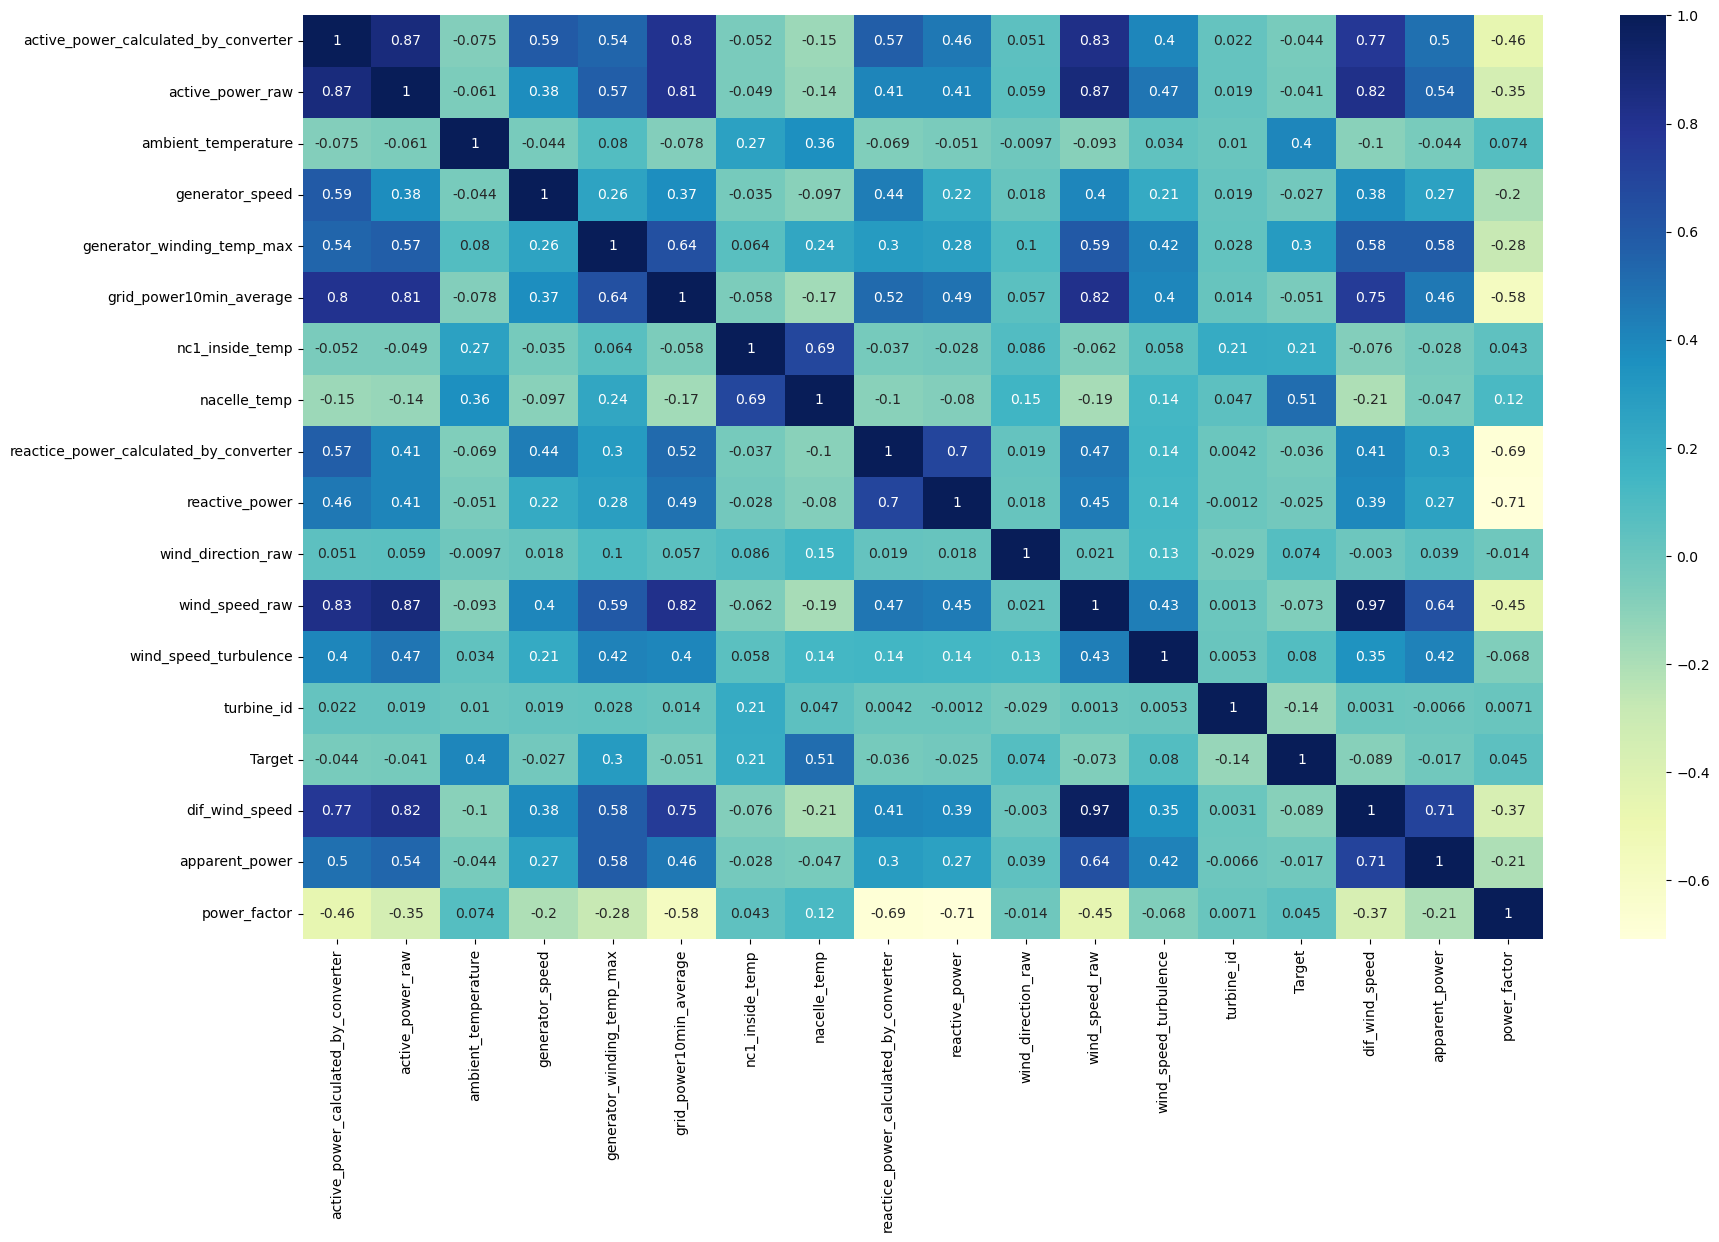

In [19]:
sns.heatmap(train.corr(),cmap='YlGnBu',annot=True)
plt.show()

# Visualizations

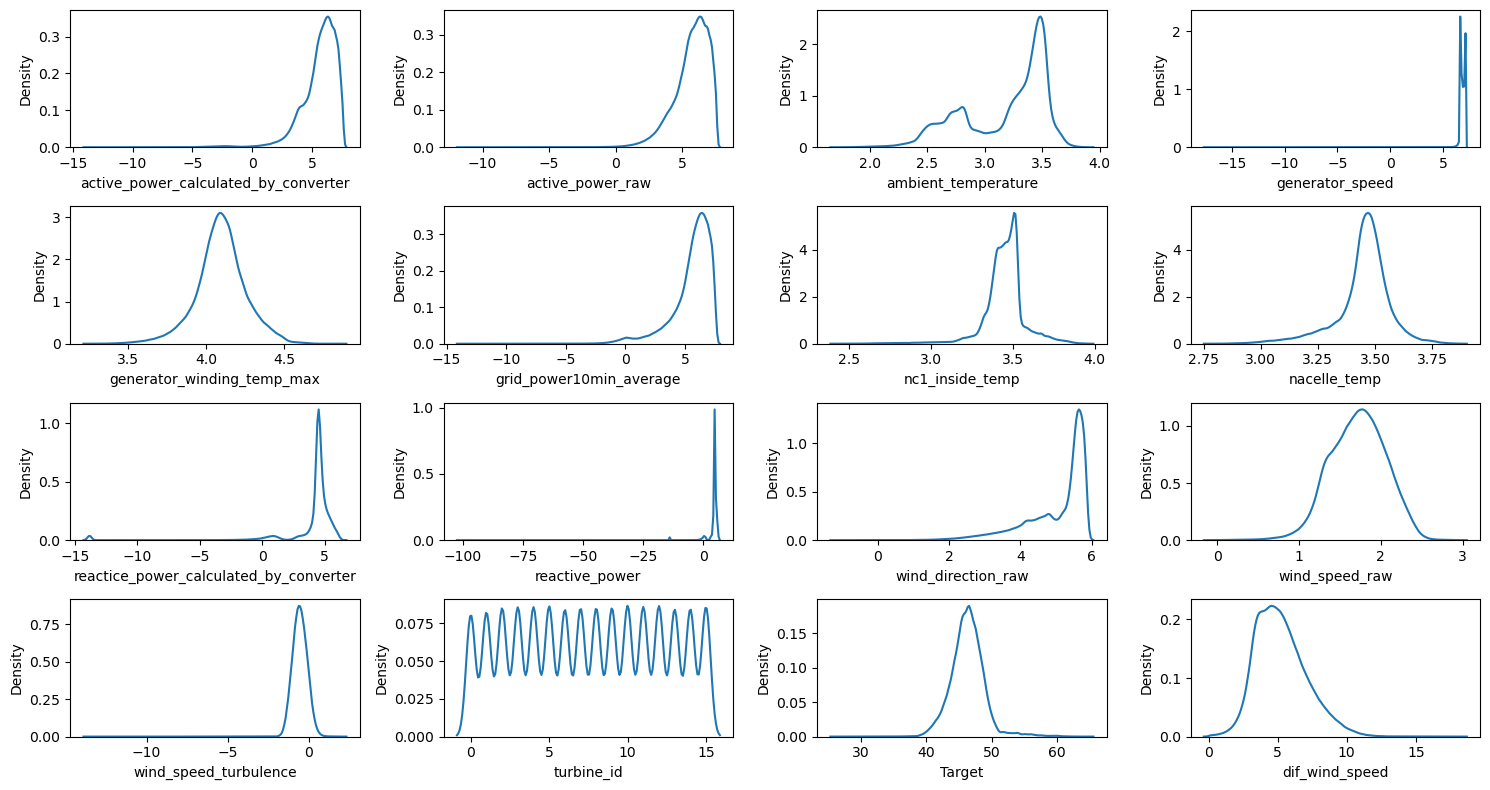

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(15, 8))
for variable, subplot in zip(train.select_dtypes(np.number).columns, ax.flatten()):
    z = sns.kdeplot(x = train.select_dtypes(np.number)[variable], ax=subplot)
    z.set_xlabel(variable, fontsize = 10)
plt.tight_layout()

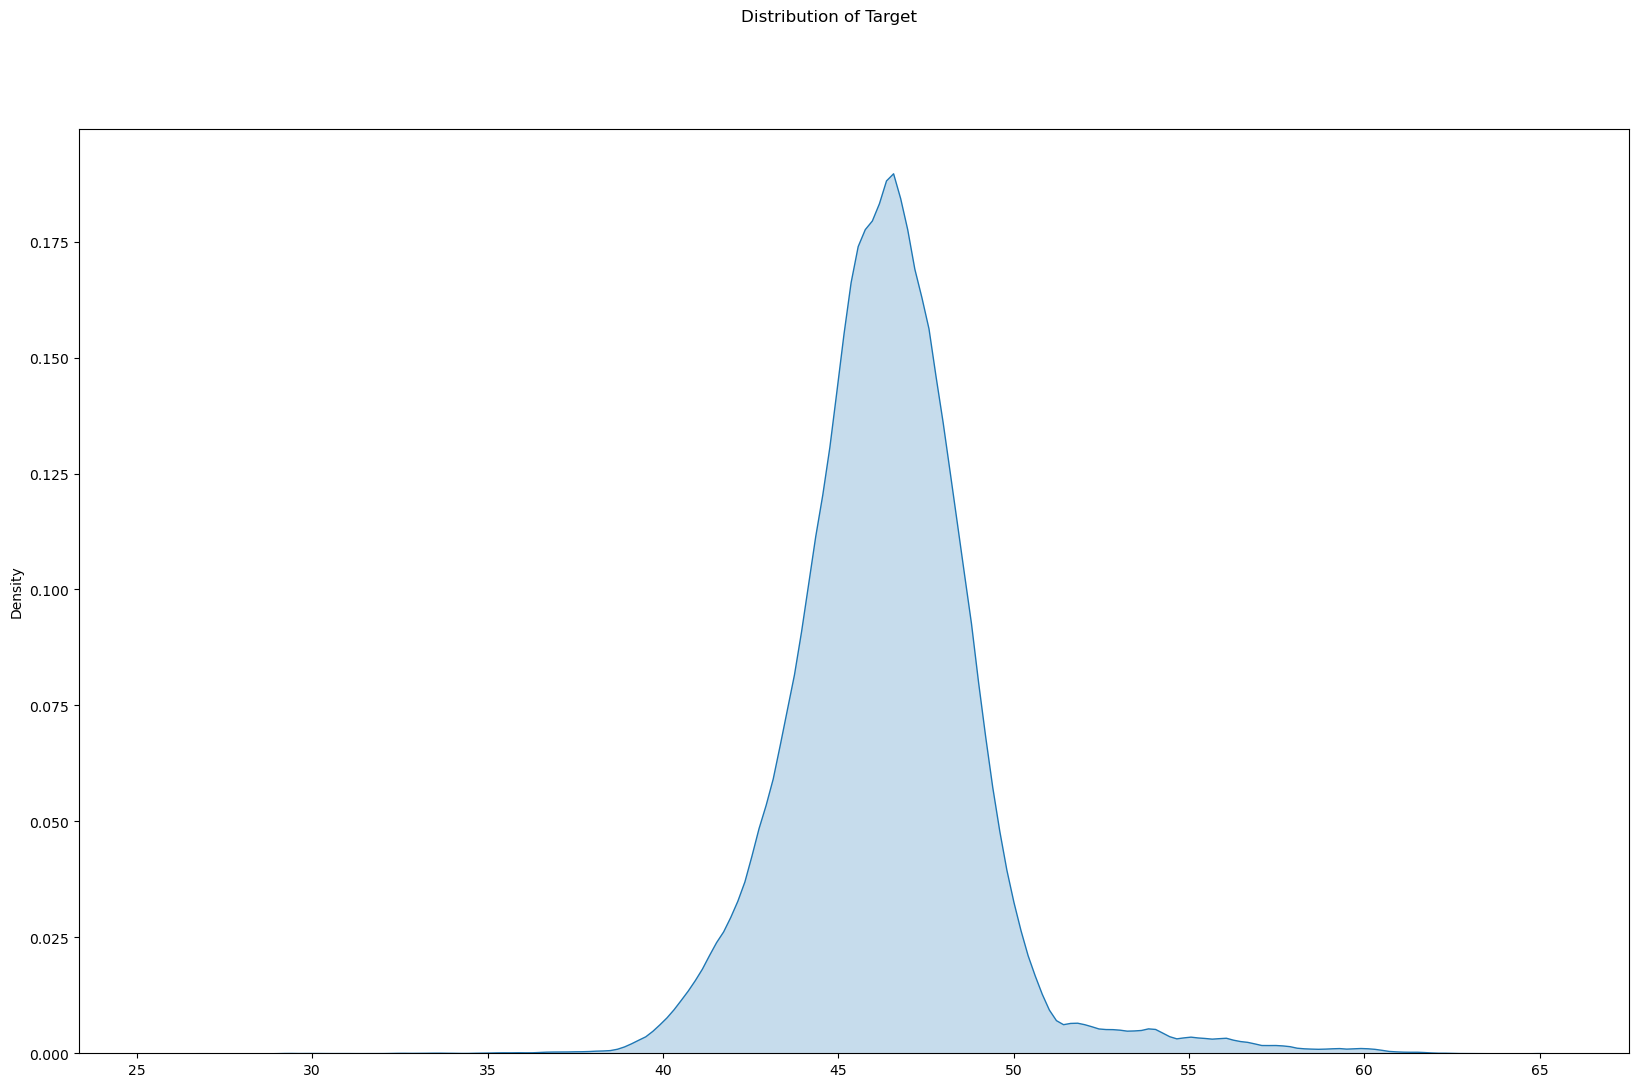

In [21]:
p = sns.kdeplot((train['Target'].values), shade=True) 
t = plt.suptitle("Distribution of Target")

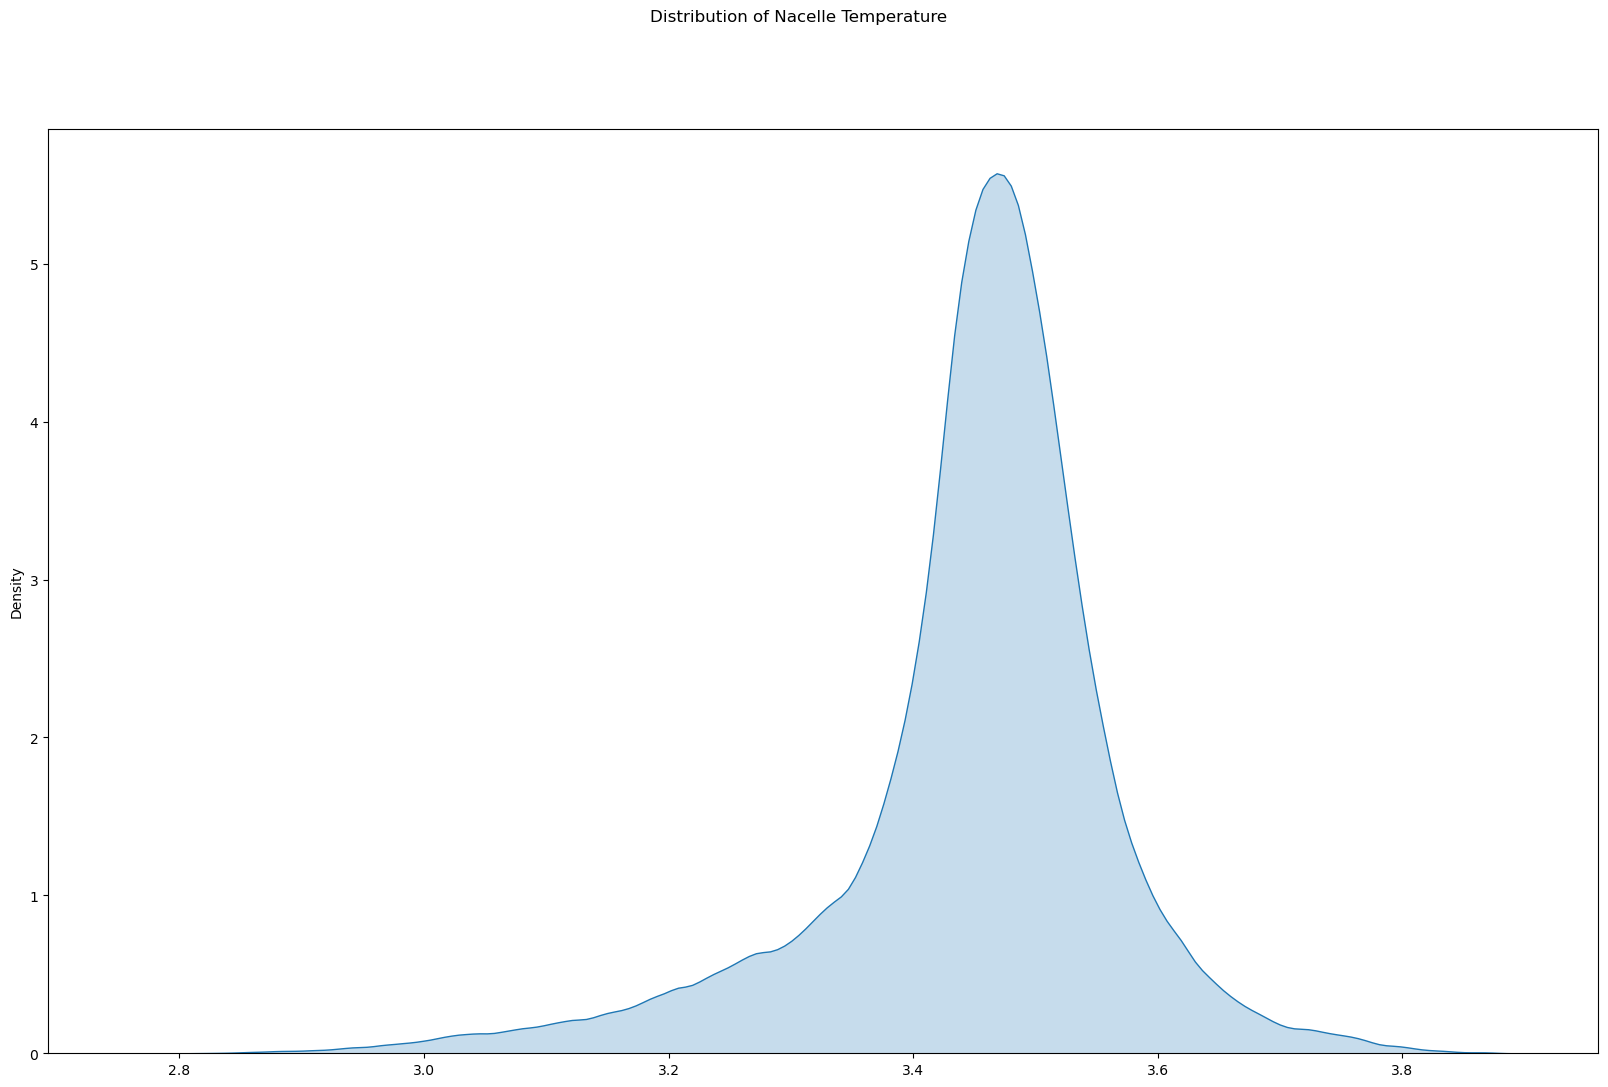

In [22]:
p = sns.kdeplot((train['nacelle_temp'].values), shade=True)
t= plt.suptitle("Distribution of Nacelle Temperature")

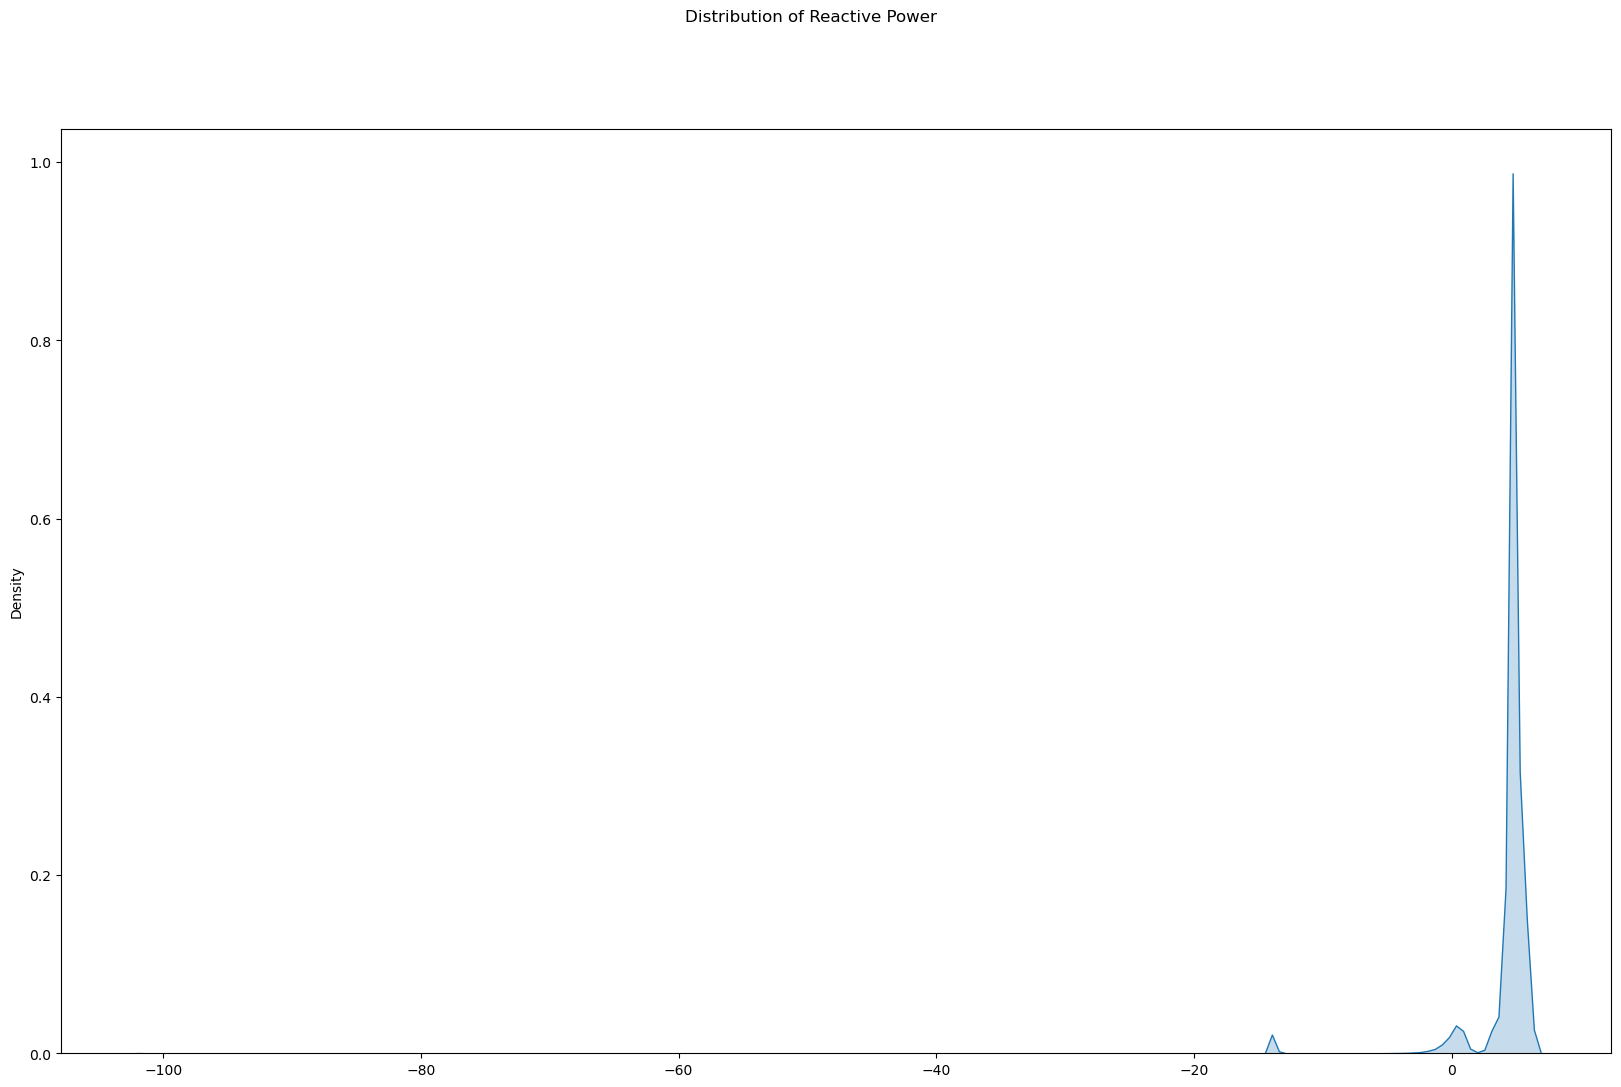

In [23]:
p = sns.kdeplot((train['reactive_power'].values), shade=True)
t= plt.suptitle("Distribution of Reactive Power")

In [24]:
# Scaling the Data Sets 
scale_features = ['active_power_calculated_by_converter', 'active_power_raw','ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
                   'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp','reactice_power_calculated_by_converter', 'reactive_power',
                   'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence']
scale = StandardScaler()
for fs in scale_features:
    train[fs] = scale.fit_transform(train[[fs]])
    test[fs] = scale.fit_transform(test[[fs]])

# Train-test split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.01, random_state=42)
X_train.shape, X_test.shape

((900507, 15), (9097, 15))

# Feature Selection

### mutual_info_regression

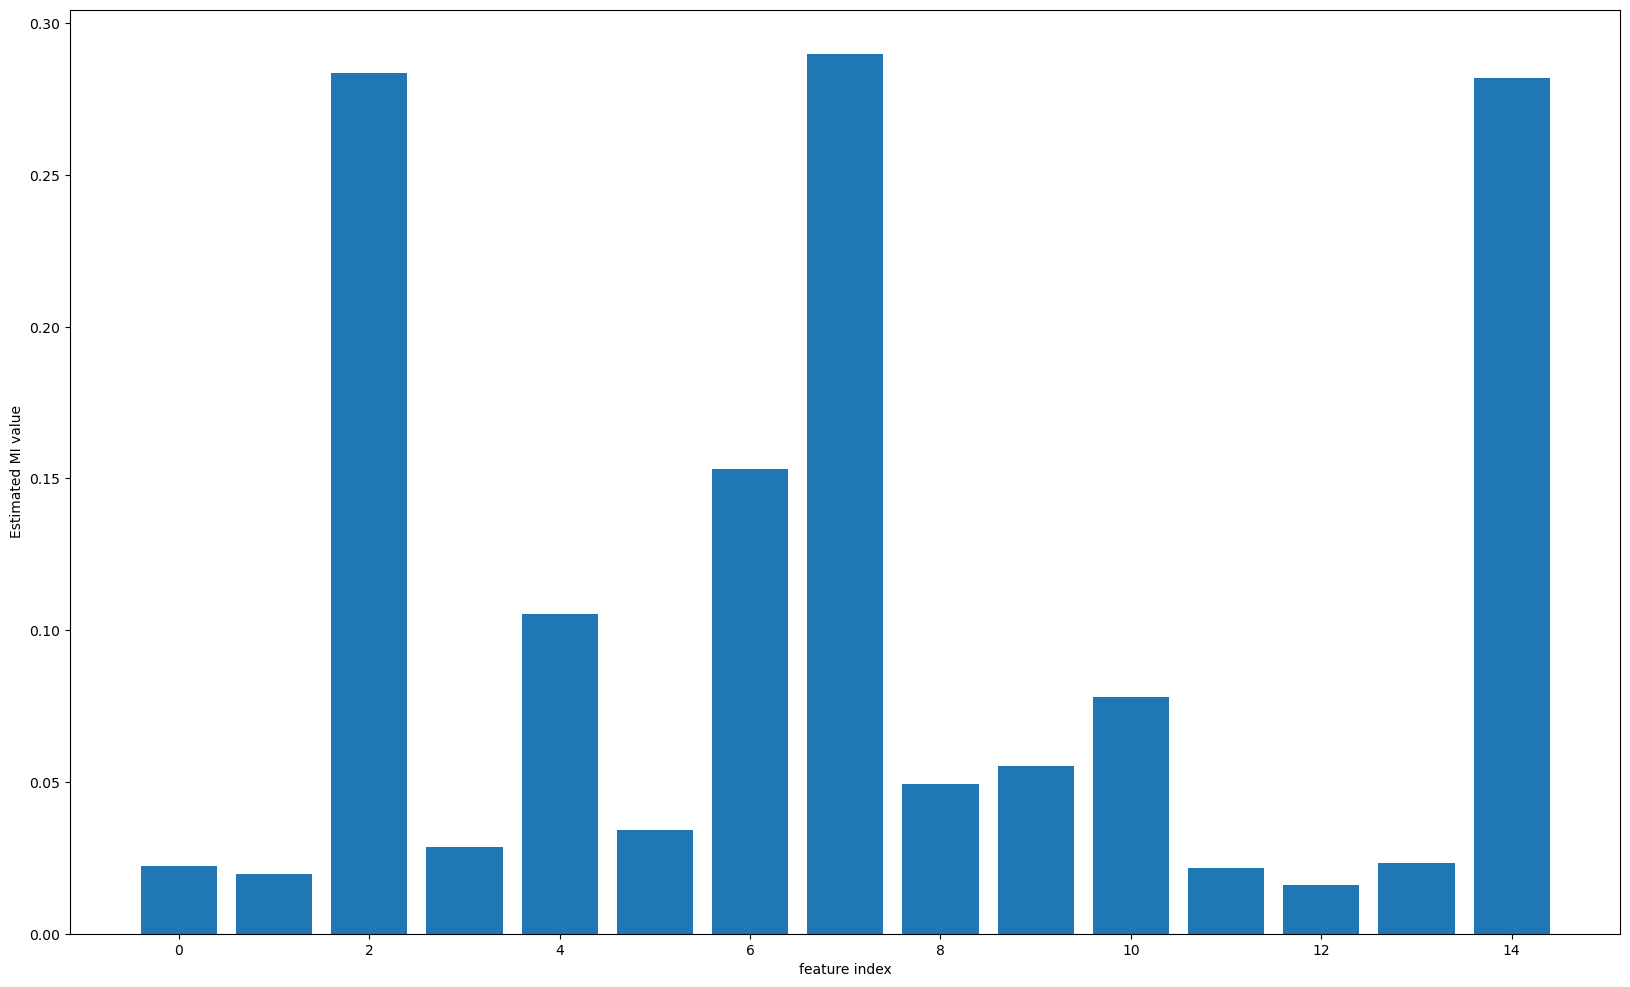

In [97]:
# feature selection
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()

# Random Forest Regressor

In [ ]:
%%time
rfr = RandomForestRegressor(n_estimators=50,criterion='absolute_error',max_depth=12,random_state=42)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

rsq_baseline_rfr = r2_score(y_true=y_test, y_pred=y_pred_rfr)
adj_rsq_baseline_rfr = adjusted_r2_score(y_true=y_test, y_pred=y_pred_rfr, X_test=X_test)
rmse_baseline_rfr = mean_squared_error(y_true=y_test, y_pred=y_pred_rfr) ** 0.5
mape_baseline_rfr = MAPE(y_actual=y_test, y_pred=y_pred_rfr)
print('R-sq:', rsq_baseline_rfr)
print('Adj. R-sq:', adj_rsq_baseline_rfr)
print('RMSE:', rmse_baseline_rfr)
print('MAPE:', mape_baseline_rfr)

# Catboost Regressor

In [29]:
%%time
cbr = CatBoostRegressor(iterations=200,learning_rate=0.7,loss_function='MAPE',random_state=42)
cbr.fit(X_train, y_train)

y_pred_cbr = cbr.predict(X_test)

rsq_baseline_cbr = r2_score(y_true=y_test, y_pred=y_pred_cbr)
adj_rsq_baseline_cbr = adjusted_r2_score(y_true=y_test, y_pred=y_pred_cbr, X_test=X_test)
rmse_baseline_cbr = mean_squared_error(y_true=y_test, y_pred=y_pred_cbr) ** 0.5
mape_baseline_cbr = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_cbr)
print('R-sq:', rsq_baseline_cbr)
print('Adj. R-sq:', adj_rsq_baseline_cbr)
print('RMSE:', rmse_baseline_cbr)
print('MAPE:', mape_baseline_cbr)

0:	learn: 0.0342236	total: 115ms	remaining: 23s
1:	learn: 0.0306996	total: 219ms	remaining: 21.7s
2:	learn: 0.0286200	total: 325ms	remaining: 21.4s
3:	learn: 0.0273781	total: 431ms	remaining: 21.1s
4:	learn: 0.0265019	total: 529ms	remaining: 20.6s
5:	learn: 0.0258883	total: 638ms	remaining: 20.6s
6:	learn: 0.0253316	total: 740ms	remaining: 20.4s
7:	learn: 0.0250350	total: 837ms	remaining: 20.1s
8:	learn: 0.0247415	total: 942ms	remaining: 20s
9:	learn: 0.0244842	total: 1.04s	remaining: 19.8s
10:	learn: 0.0243388	total: 1.14s	remaining: 19.6s
11:	learn: 0.0239263	total: 1.25s	remaining: 19.6s
12:	learn: 0.0238318	total: 1.35s	remaining: 19.4s
13:	learn: 0.0236924	total: 1.45s	remaining: 19.2s
14:	learn: 0.0235363	total: 1.55s	remaining: 19.1s
15:	learn: 0.0234426	total: 1.65s	remaining: 19s
16:	learn: 0.0233775	total: 1.75s	remaining: 18.8s
17:	learn: 0.0232151	total: 1.86s	remaining: 18.8s
18:	learn: 0.0231233	total: 1.99s	remaining: 18.9s
19:	learn: 0.0230647	total: 2.09s	remaining: 18

161:	learn: 0.0204328	total: 16.2s	remaining: 3.79s
162:	learn: 0.0204274	total: 16.3s	remaining: 3.69s
163:	learn: 0.0204237	total: 16.4s	remaining: 3.59s
164:	learn: 0.0204200	total: 16.5s	remaining: 3.49s
165:	learn: 0.0204153	total: 16.6s	remaining: 3.39s
166:	learn: 0.0204120	total: 16.7s	remaining: 3.29s
167:	learn: 0.0204105	total: 16.8s	remaining: 3.19s
168:	learn: 0.0204065	total: 16.9s	remaining: 3.09s
169:	learn: 0.0204028	total: 17s	remaining: 2.99s
170:	learn: 0.0203979	total: 17.1s	remaining: 2.89s
171:	learn: 0.0203959	total: 17.2s	remaining: 2.79s
172:	learn: 0.0203929	total: 17.2s	remaining: 2.69s
173:	learn: 0.0203915	total: 17.3s	remaining: 2.59s
174:	learn: 0.0203821	total: 17.4s	remaining: 2.49s
175:	learn: 0.0203803	total: 17.5s	remaining: 2.39s
176:	learn: 0.0203786	total: 17.6s	remaining: 2.29s
177:	learn: 0.0203786	total: 17.7s	remaining: 2.19s
178:	learn: 0.0203785	total: 17.8s	remaining: 2.09s
179:	learn: 0.0203772	total: 17.9s	remaining: 1.99s
180:	learn: 0.

# XGBoost Regressor

In [32]:
%%time
xgr = XGBRegressor(booster='gbtree',n_estimators=200,max_depth=12,random_state=42)
xgr.fit(X_train, y_train)

y_pred_xgb = xgr.predict(X_test)

rsq_baseline_xgb = r2_score(y_true=y_test, y_pred=y_pred_xgb)
adj_rsq_baseline_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred_xgb, X_test=X_test)
rmse_baseline_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb) ** 0.5
mape_baseline_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb)
print('R-sq:', rsq_baseline_xgb)
print('Adj. R-sq:', adj_rsq_baseline_xgb)
print('RMSE:', rmse_baseline_xgb)
print('MAPE:', mape_baseline_xgb)

R-sq: 0.8274532329750061
Adj. R-sq: 0.8271682201454306
RMSE: 1.0635484989615451
MAPE: 0.015646132568848448
CPU times: total: 53min 38s
Wall time: 7min 45s


# Extra Trees Regressor

In [31]:
%%time
etr = ExtraTreesRegressor(random_state=42,n_estimators=200,max_depth=12)
etr.fit(X_train, y_train)

y_pred_etr = etr.predict(X_test)

rsq_baseline_etr = r2_score(y_true=y_test, y_pred=y_pred_etr)
adj_rsq_baseline_etr = adjusted_r2_score(y_true=y_test, y_pred=y_pred_etr, X_test=X_test)
rmse_baseline_etr = mean_squared_error(y_true=y_test, y_pred=y_pred_etr) ** 0.5
mape_baseline_etr = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_etr)
print('R-sq:', rsq_baseline_etr)
print('Adj. R-sq:', adj_rsq_baseline_etr)
print('RMSE:', rmse_baseline_etr)
print('MAPE:', mape_baseline_etr)

R-sq: 0.6723050595725955
Adj. R-sq: 0.6717637729184371
RMSE: 1.4656786232721652
MAPE: 0.02122890434640617
CPU times: total: 7min
Wall time: 7min 2s


# LightGBM Regressor

In [30]:
%%time
lgbm =LGBMRegressor(n_estimators=800,max_depth=12,learning_rate=0.7,random_state=42)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

rsq_baseline_lgbm = r2_score(y_true=y_test, y_pred=y_pred_lgbm)
adj_rsq_baseline_lgbm = adjusted_r2_score(y_true=y_test, y_pred=y_pred_lgbm, X_test=X_test)
rmse_baseline_lgbm = mean_squared_error(y_true=y_test, y_pred=y_pred_lgbm) ** 0.5
mape_baseline_lgbm = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_lgbm)
print('R-sq:', rsq_baseline_lgbm)
print('Adj. R-sq:', adj_rsq_baseline_lgbm)
print('RMSE:', rmse_baseline_lgbm)
print('MAPE:', mape_baseline_lgbm)

R-sq: 0.7935312479378991
Adj. R-sq: 0.7931902027577502
RMSE: 1.1634053381985303
MAPE: 0.01730036718198639
CPU times: total: 1min 39s
Wall time: 13.7 s


# LGBM Regression with HyperOpt

In [52]:
def objective(search_space):
    model = LGBMRegressor(n_estimators = search_space["n_estimators"],
                              max_depth = int(search_space["max_depth"]),
                             learning_rate = search_space["learning_rate"],
                              reg_alpha = int(search_space["reg_alpha"]),
                              min_child_weight = search_space["min_child_weight"],
                              colsample_bytree = search_space["colsample_bytree"],
                              n_jobs = -1,
                              random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_absolute_percentage_error(y_test, y_pred)
    return {"loss": score, "status": STATUS_OK}

In [53]:
search_space = {"max_depth": hp.quniform("max_depth", 3, 18, 1),
                "reg_alpha" : hp.quniform("reg_alpha", 40, 180, 1),
                "reg_lambda": hp.uniform("reg_lambda", 0, 1),
                "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
                "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
                "n_estimators": hp.choice("n_estimators",range(100,300,10)),
                "learning_rate": hp.choice("learning_rate",[0.01,0.02,.1,.2,.03])
               }

In [54]:
trials = Trials()

best_params = fmin(fn = objective,
                   space = search_space,
                   algo = tpe.suggest,
                   max_evals = 100,
                   trials = trials)

100%|████████████████████████████████████████████| 100/100 [12:47<00:00,  7.68s/trial, best loss: 0.018258499708900172]


In [59]:
best_params

{'colsample_bytree': 0.9612078718187468,
 'learning_rate': 3,
 'max_depth': 12.0,
 'min_child_weight': 3.0,
 'n_estimators': 19,
 'reg_alpha': 50.0,
 'reg_lambda': 0.78355852987255}

In [51]:
feat_select=['active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'dif_wind_speed', 'turbine_id']

In [53]:
xgb_predictions = xgr.predict(test[feat_select])
etr_predictions = etr.predict(test[feat_select])
cbr_predictions = cbr.predict(test[feat_select])
lgbm_predictions = lgbm.predict(test[feat_select])

submissions=(lgbm_predictions+xgb_predictions)/2

submission=pd.DataFrame([submissions]).T
submission.rename(columns={0:'Target'},inplace=True)
submission.to_csv('my_submission.csv',index = False)